In [326]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 
import keras.backend as K
from keras.models import *
from keras.layers import *

from keras import optimizers
from keras.callbacks import *

#import models
#from Linear_Regression import linear_regression 

#import datetime for tensorboard
from datetime import *

#Import for reading the MATLAB files
import glob

#Preprocessing using scikit learn 
from sklearn.preprocessing import MinMaxScaler

In [327]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [328]:
!ls

 1filtered.mat
 1.mat
 2.mat
 3.mat
 4.mat
 5.mat
 baseline_linear_regression.ipynb
'linear_reg python3final7.ipynb'
 Linear_Regression.ipynb
 Linear_Regression.py
 logs
 vanilla_RNN_keras_GoogleColab_cross_correlation_stim_EEG.ipynb
 vanilla_RNN_keras_GoogleColab_forecasting_EEG.ipynb
'Visualizing EEG_Data .ipynb'


In [329]:


# data import from matlab
subject_1 = sio.loadmat('1filtered.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


/home/vasu/PycharmProjects/EEG/venv_eeg/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


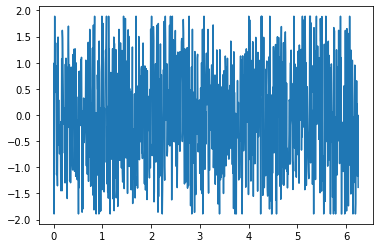

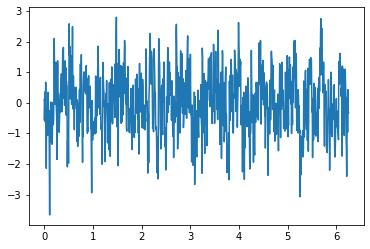

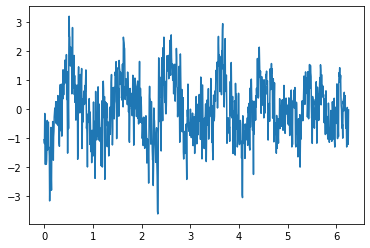

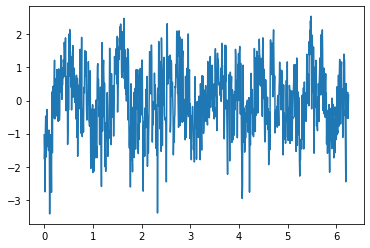

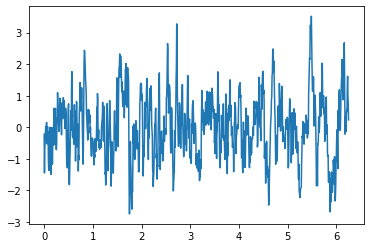

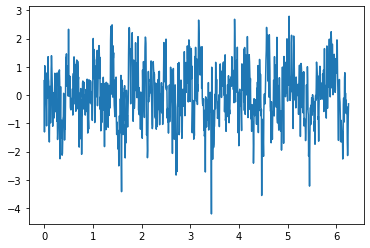

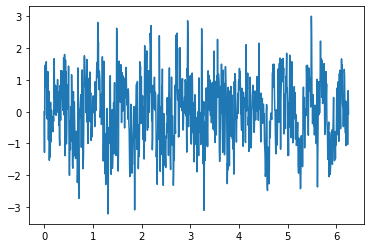

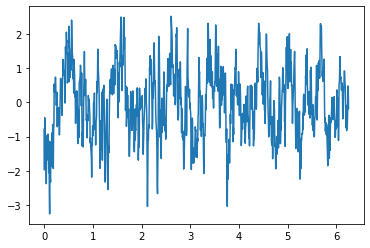

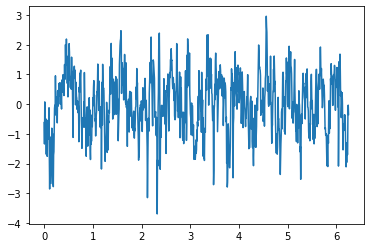

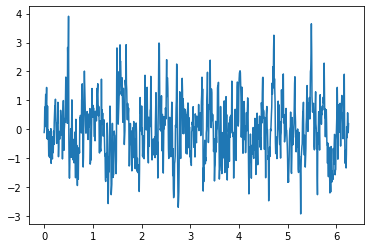

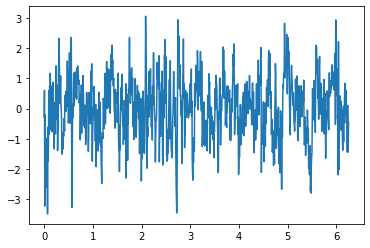

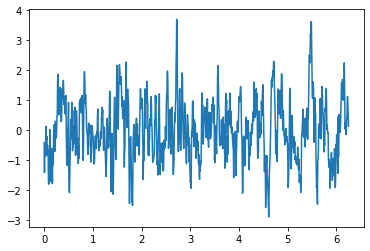

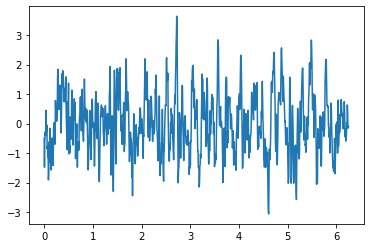

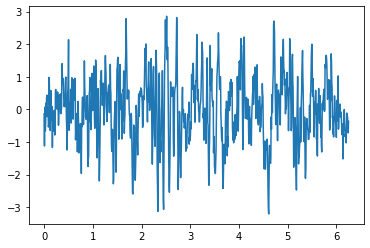

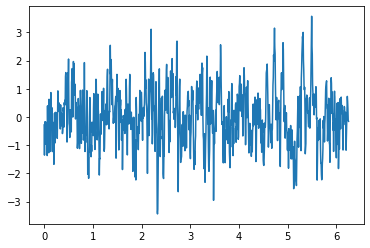

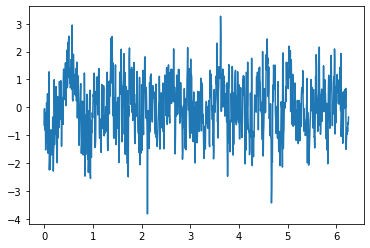

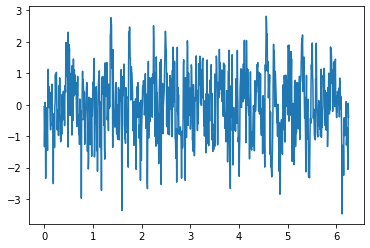

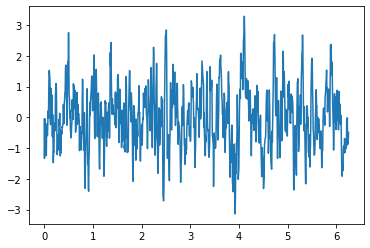

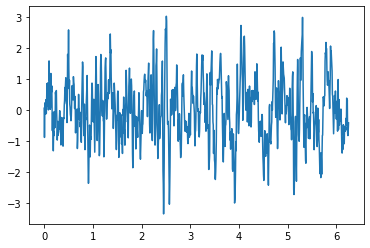

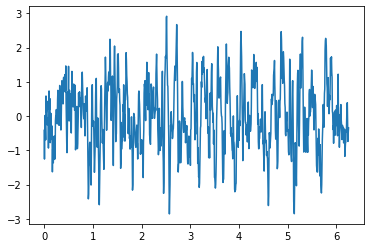

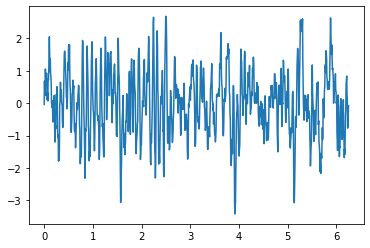

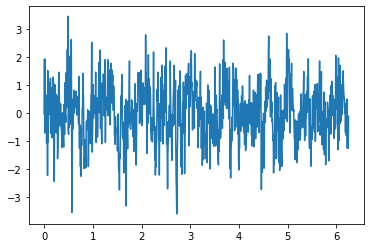

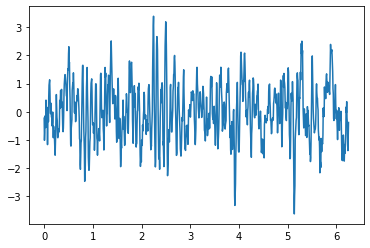

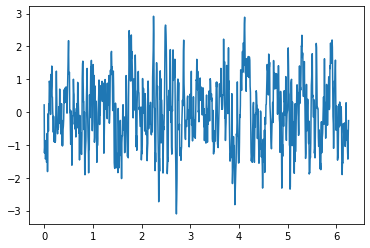

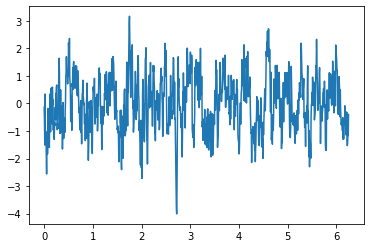

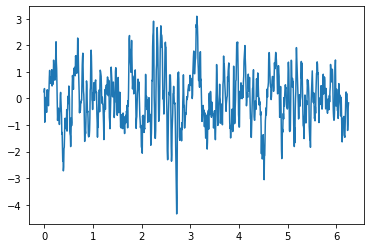

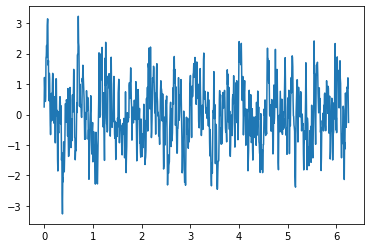

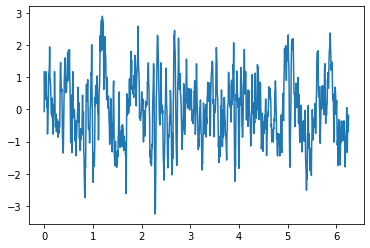

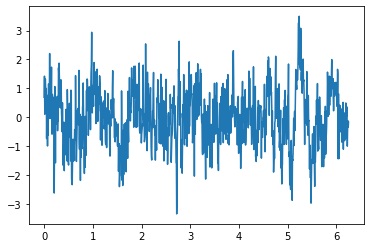

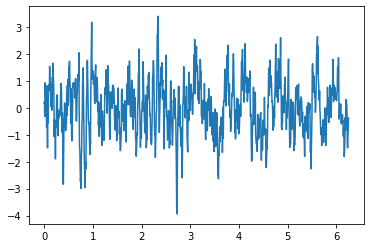

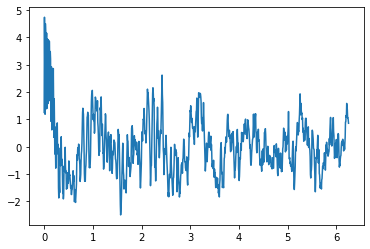

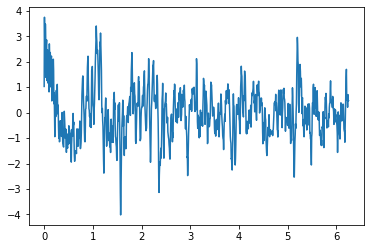

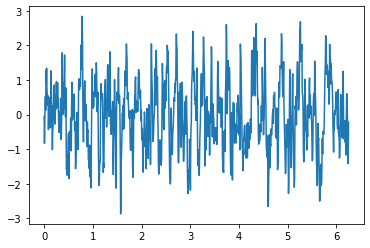

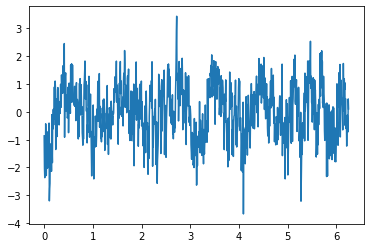

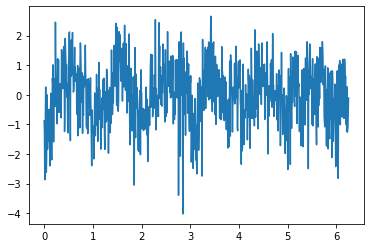

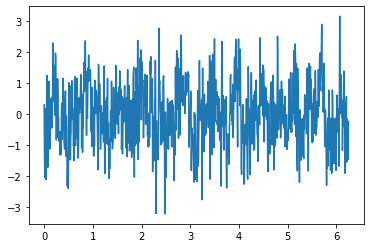

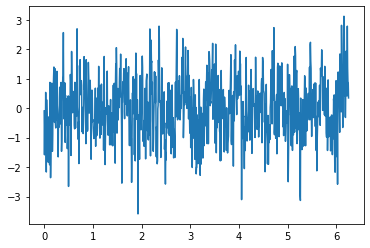

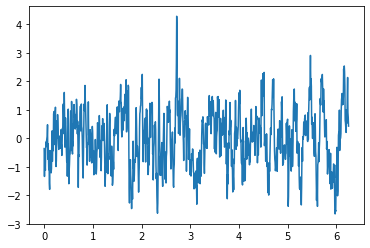

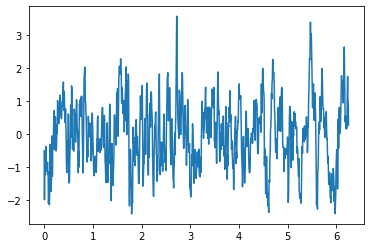

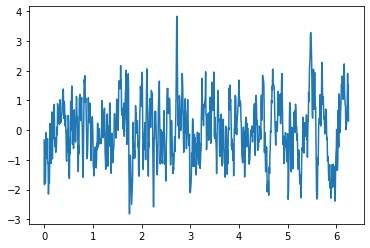

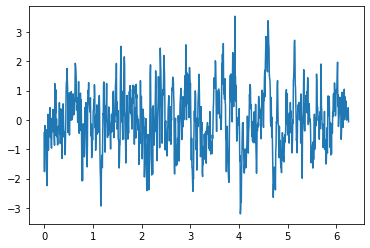

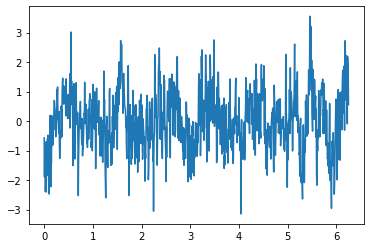

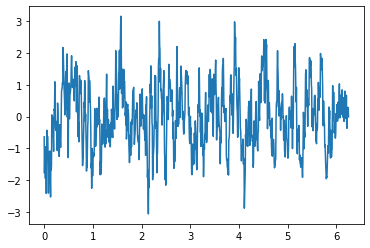

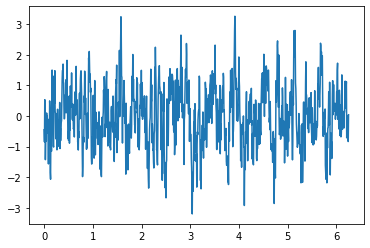

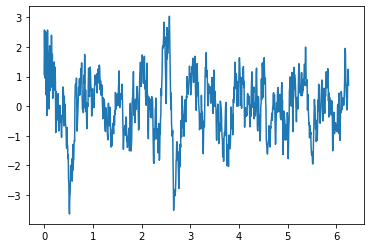

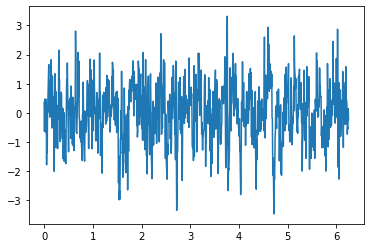

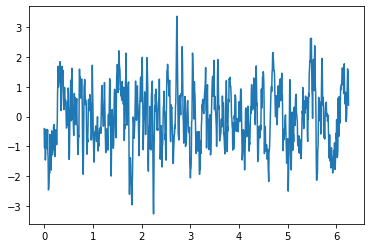

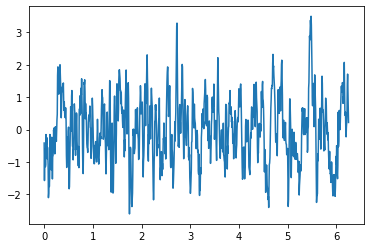

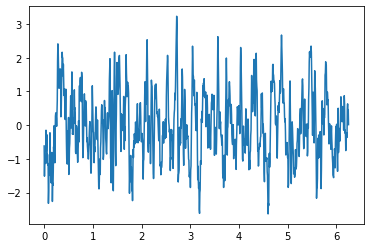

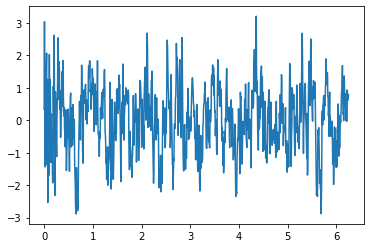

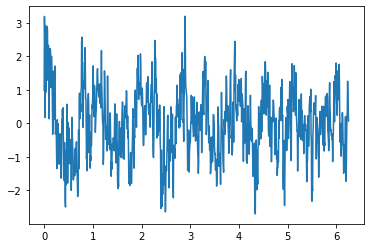

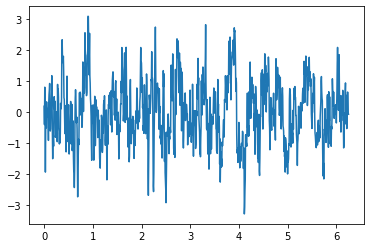

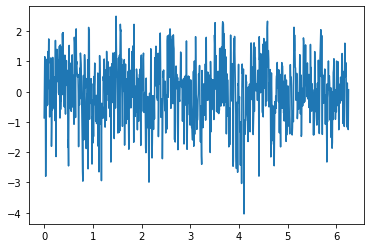

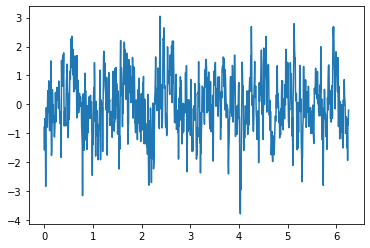

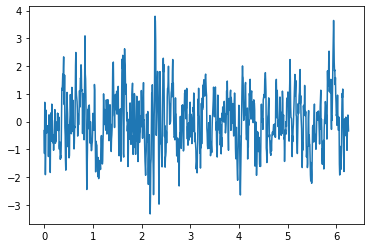

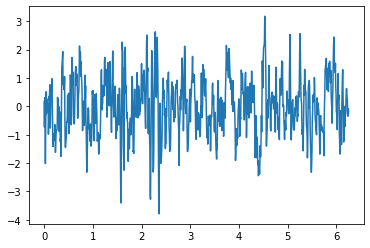

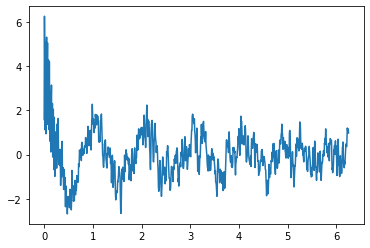

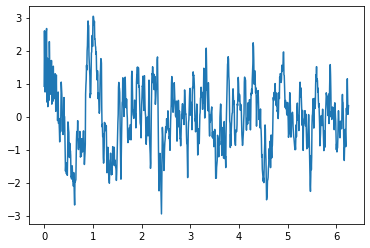

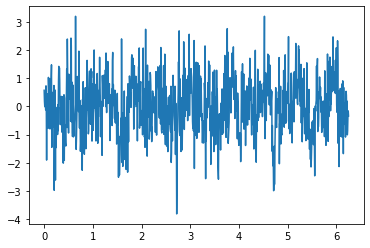

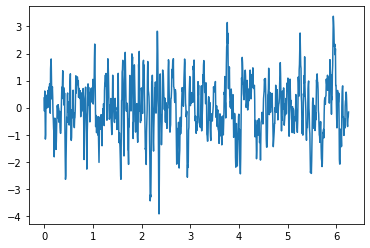

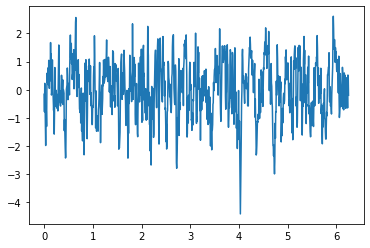

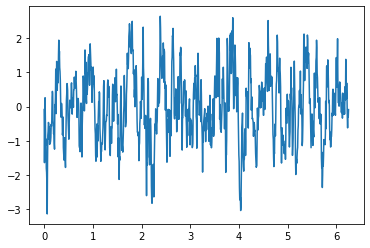

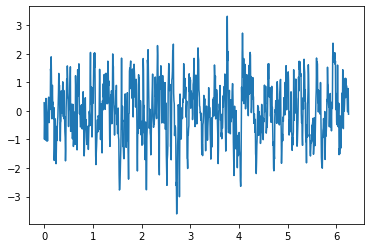

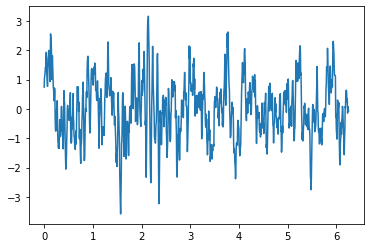

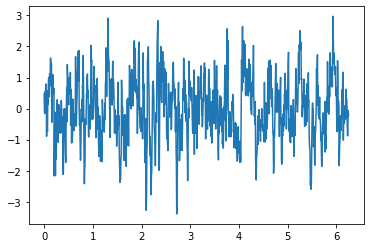

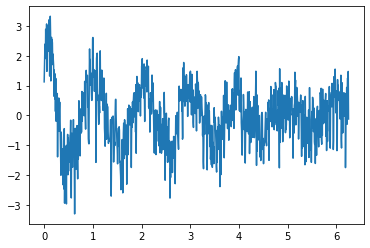

In [164]:
#Plot EEG
#plot of a single channel of EEG
%matplotlib inline
Time = np.linspace(0, 6.25, 1000)
for i in range (channel):
    plt.plot(Time, format_1[i][0])
    plt.figure()
plt.plot(Time, format_1[52][1])



/home/vasu/PycharmProjects/EEG/venv_eeg/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


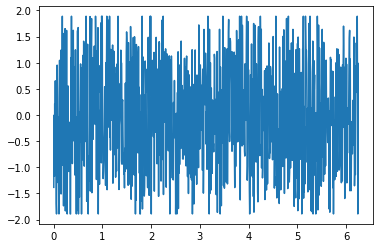

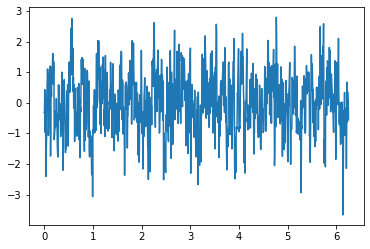

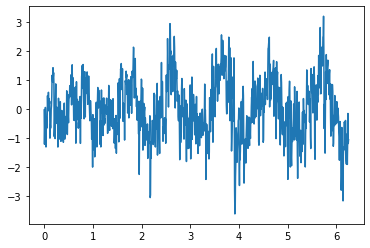

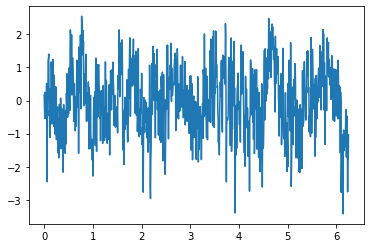

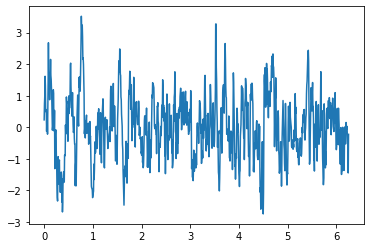

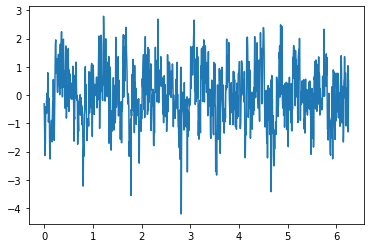

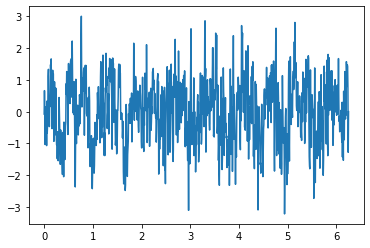

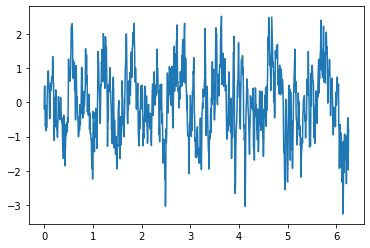

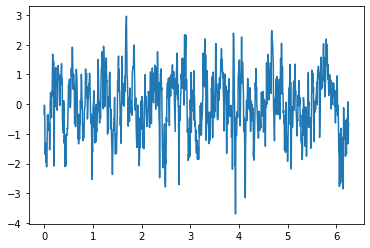

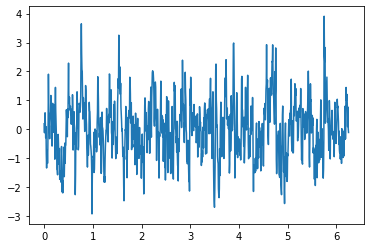

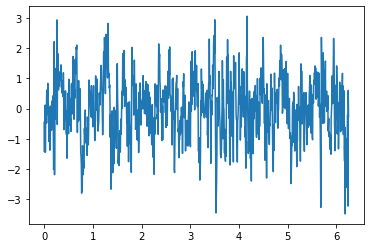

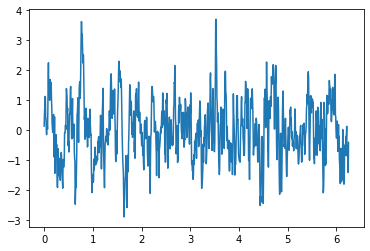

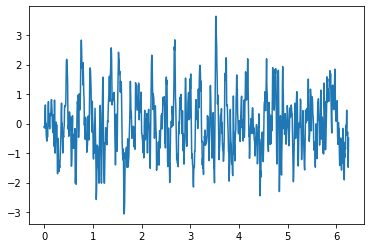

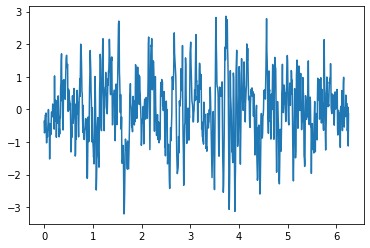

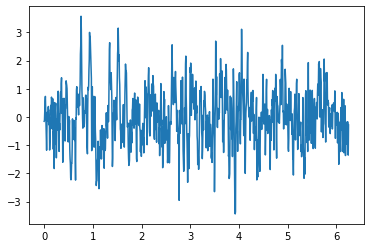

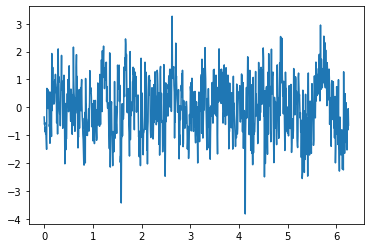

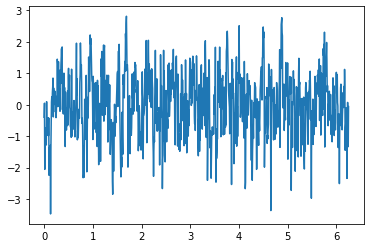

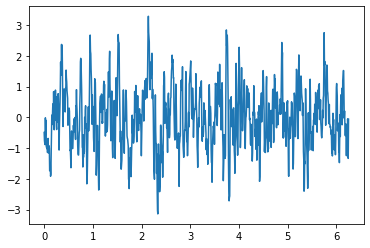

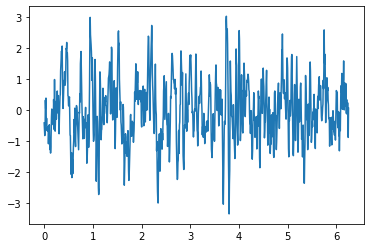

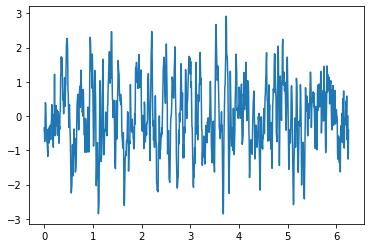

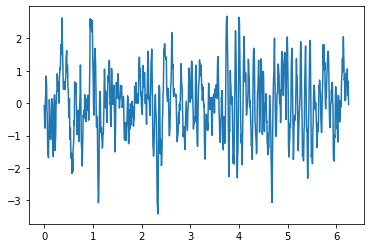

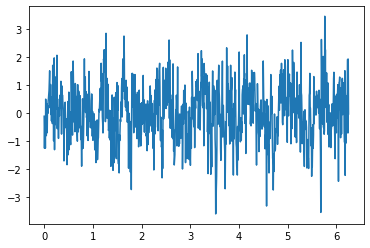

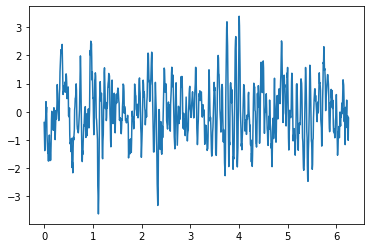

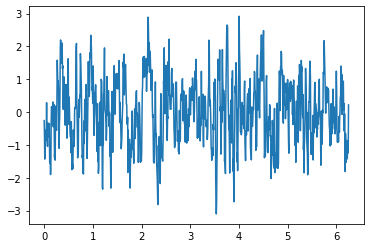

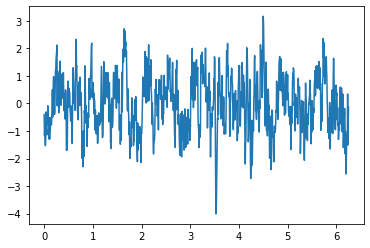

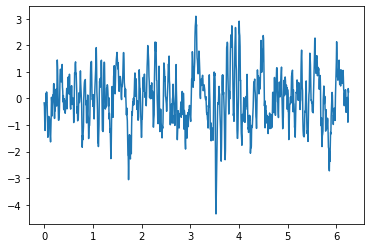

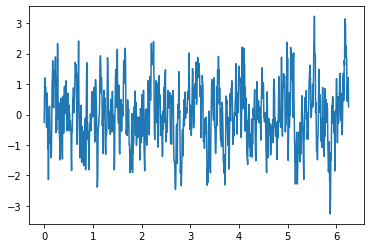

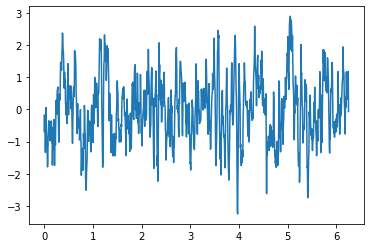

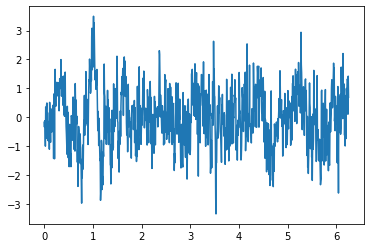

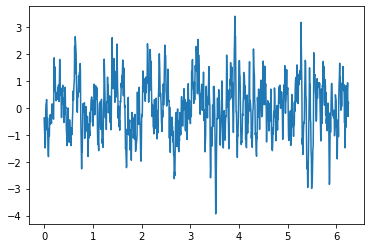

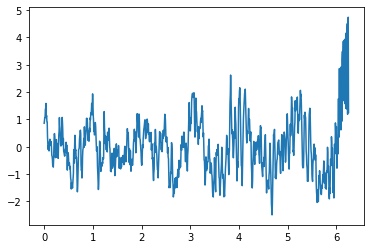

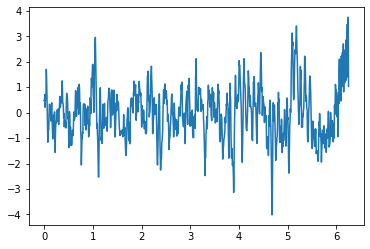

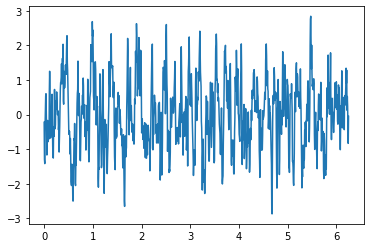

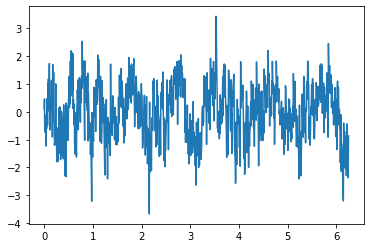

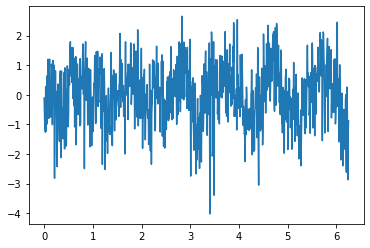

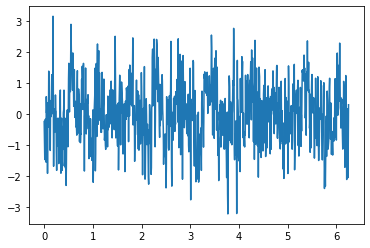

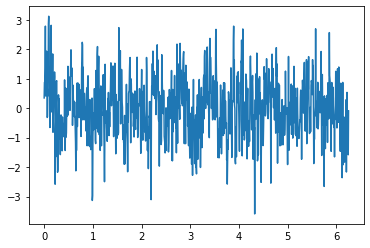

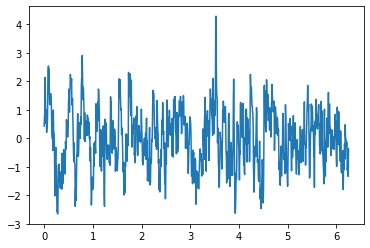

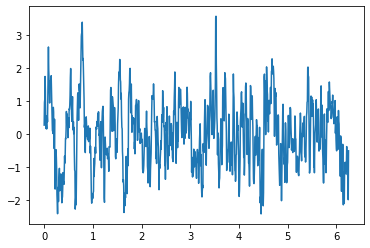

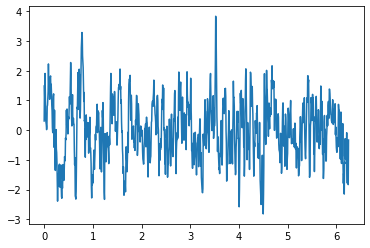

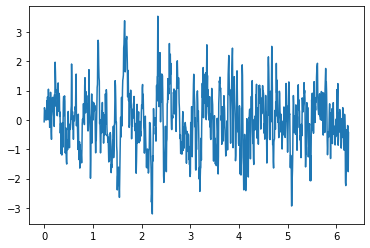

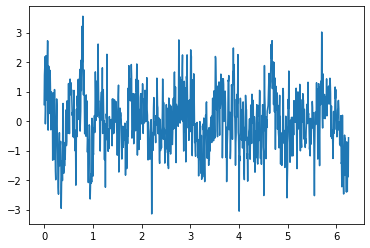

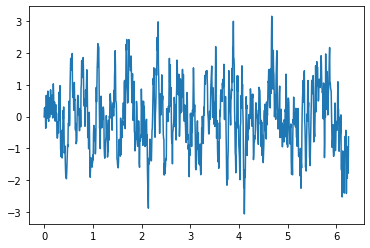

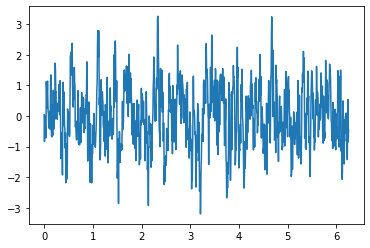

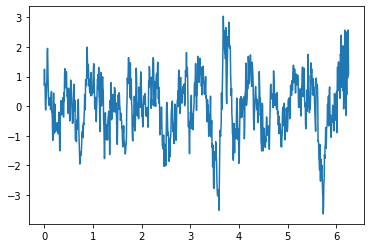

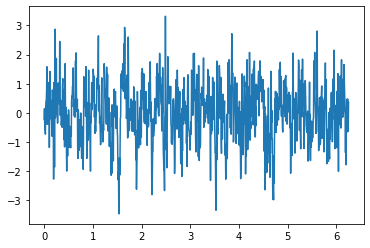

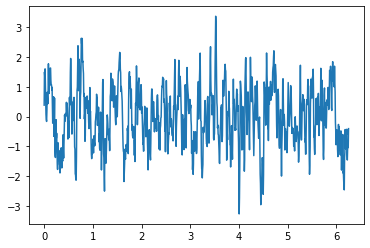

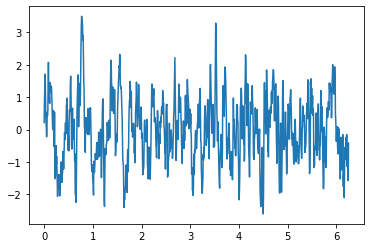

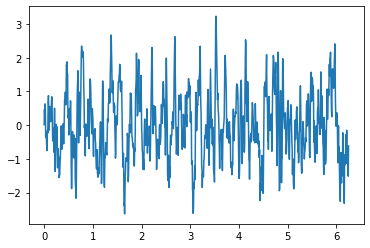

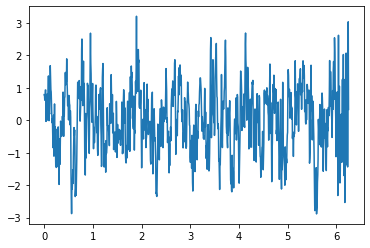

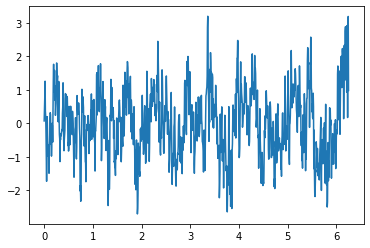

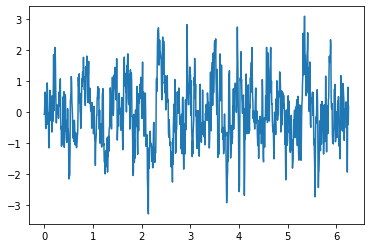

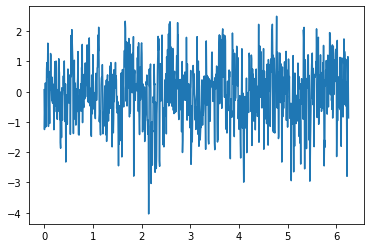

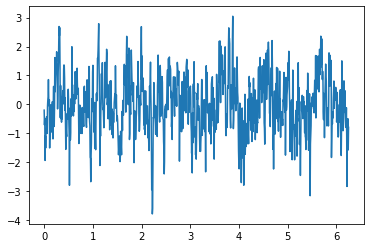

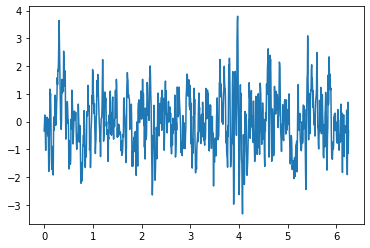

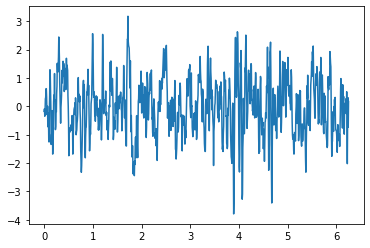

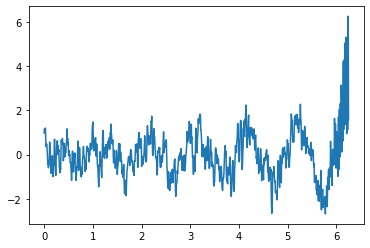

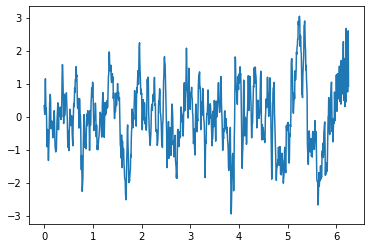

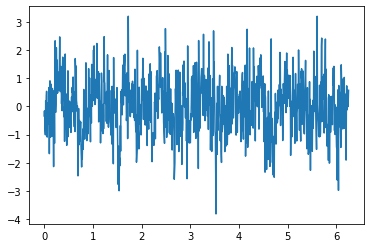

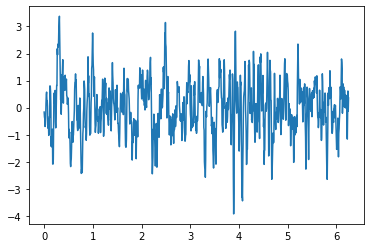

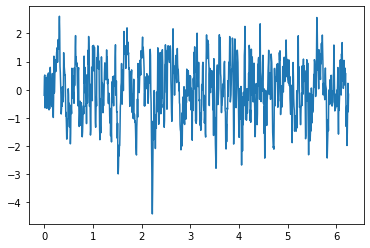

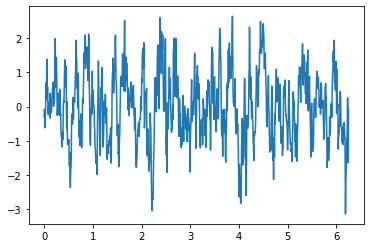

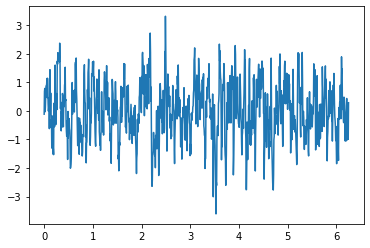

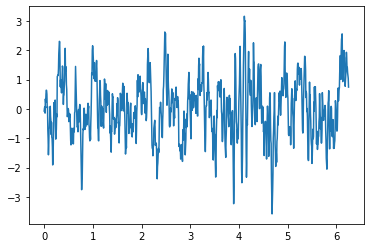

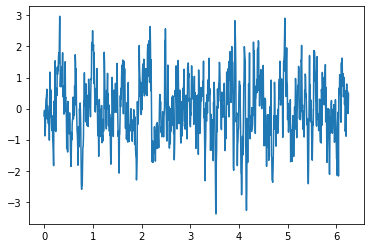

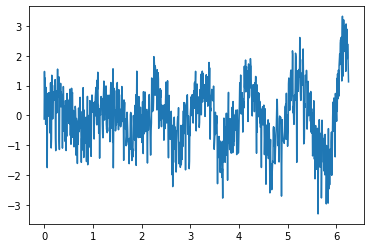

In [340]:
#Plot EEG
#plot of a single channel of EEG
%matplotlib inline
Time = np.linspace(0, 6.25, 1000)
for i in range (channel):
    plt.plot(Time, format_1[i][0])
    plt.figure()
plt.plot(Time, format_1[52][1])


In [333]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

stim = input ('''Enter the number of stimuli:''')
stim = int(stim)

relation = input('''Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):''')

if relation == '1':
    response = input("Do you want to embed information of EEG as well ? ( 1 for yes or 2 for no)")
    
    if response == "2":
        source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
        source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X
    else:
        source_Y = electi[0]
        source_X = [0] + electi[0]

elif relation == '2':
    format_1[0] = np.flip(format_1,1)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi
    
elif relation == '3':
    response = input("Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)")
    
    if response == "2":
        source_Y = electi
        source_X = electi
    else: 
        source_Y = electi
        source_X = electi + [0]

hiLaSi_tmp = input('''please specify the number of layers and neurons per desired layers: ''')
hidden_layers = list(map(int, hiLaSi_tmp.split()))
print (hidden_layers)
print (type(hidden_layers))

learning_rate = input('''enter the lambda / learning rate: ''')
learning_rate = float(learning_rate)      # conversion as a decimal number

Enter the electrode number:30
<class 'list'>
[30]
Enter the number of stimuli:160
Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):2
please specify the number of layers and neurons per desired layers: 1
[1]
<class 'list'>
enter the lambda / learning rate: 0.01


In [334]:
def split_data(data):
    (subject, channel, trial, time_points) = data.shape
    
    #Sepration of train train / valid / test sets into 80 %, 10 % and 10 % of the data respectively.
    
    train_num = int(np.around(len(trials) * 0.8))
    valid_num = int(np.around(len(trials) * 0.1))
    test_num = len(trials) - train_num - valid_num


In [335]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num

trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]

In [336]:
# extract data from format_1

def extract_Y (batch_trials, batch_num):              #creation of a function to recover y - simplification of reading
    
    y_tmp=format_1[source_Y, batch_trials, stim:]     #recovery of Y in the form of a matrix of 154 * 840
    y_tmp=np.reshape(y_tmp, ((time_points-stim)*batch_num))    #passage through the list of 129 360 values ​​(test 0, test 1, ... test 153)
    y_tmp=np.matrix(y_tmp)                           #1 * 129360 matrix conversion
    y_tmp=np.transpose(y_tmp)                        #transposition into a matrix of 129360 * 1, matrix equal to that of Matlab (necessary for the rest)
    return y_tmp                                     #returns the content of y_tmp
    
y_train = extract_Y (trials_train, train_num)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num)
print ("y_valid.shape = ", y_valid.shape)
y_test = extract_Y (trials_test, test_num)
print ("y_test.shape = ", y_test.shape)

y_train.shape =  (129360, 1)
y_valid.shape =  (15960, 1)
y_test.shape =  (15960, 1)


In [337]:
def extract_X (batch_trials, batch_num):                     #creation of a function to recover x - simplification of reading
    x_tmp = [[]]*((time_points-stim)*batch_num)                       #creation of an empty list x_tmp of size (129630,)
    x_tmp = np.matrix(x_tmp)                                #conversion as a matrix 129630 * 0 (number of lines good)
    x_tmp = np.transpose(x_tmp)                             #transposition 1: form 0 * 129630, necessary at n.append
                                                            #avoid the transposition line in the for loop (2 transpo instead of 160
    for i in source_X:                                      #reading the source list -> reading each electrode number if flip
        
        k = 0
        while k < stim:                                     #160 loops - recovery of the 840 values ​​of each test (in the form test 1, test 2, ...), shifted by 1 at each iteration
            tmp = format_1[i, batch_trials, k:(time_points-stim+k)]    #see extract_Y
            tmp = np.reshape(tmp,((time_points-stim)*batch_num))
            tmp = np.matrix(tmp)
            
            x_tmp = np.append(x_tmp, tmp, axis=0)           #concatenation of the matrix tmp 1 * 129360 at the end of the matrix x_tmp (k + 1) * 129360
            k = k+1
    x_tmp = np.transpose(x_tmp)                             #transposition 2: form 129360 * (160 * nbr_électrode)
    return x_tmp
        
x_train = extract_X (trials_train, train_num)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num)
print ("x_valid.shape = ", x_valid.shape)
x_test = extract_X (trials_test, test_num)
print ("x_test.shape = ", x_test.shape)

x_train.shape =  (129360, 160)
x_valid.shape =  (15960, 160)
x_test.shape =  (15960, 160)


In [338]:
#tensorflow - Linear regression cf github

training_epochs = 100


train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160)
(129360, 1)


In [339]:
train_X

matrix([[-2.13676876, -1.52738449, -1.26531268, ..., -1.486807  ,
         -0.98985188, -0.12200765],
        [-1.52738449, -1.26531268, -1.09848052, ..., -0.98985188,
         -0.12200765,  0.43722855],
        [-1.26531268, -1.09848052, -0.83115286, ..., -0.12200765,
          0.43722855,  0.27661019],
        ...,
        [ 0.69867808,  0.00373019, -0.41381337, ..., -1.17677326,
         -0.78790153, -0.0524576 ],
        [ 0.00373019, -0.41381337, -0.33925433, ..., -0.78790153,
         -0.0524576 , -0.29543578],
        [-0.41381337, -0.33925433, -0.00733308, ..., -0.0524576 ,
         -0.29543578, -0.63566824]])

In [271]:

def linear_regression(X_shape, hidden_layers):
    X = Input((X_shape,))
    inp = X
    for i in range(len(hidden_layers)):
        if (i==(len(hidden_layers)-1)):
            out = Dense(hidden_layers[i], activation = "linear", kernel_initializer = "normal" )(X)
        else: 
            X = Dense(hidden_layers[i], activation = "relu", kernel_initializer = "normal" )(X)
            
    model = Model(inputs = inp , output = out)
    return model 

In [309]:
K.clear_session()
learning_rate = 0.1

In [310]:
#Define Keras Model 
model = linear_regression(train_X.shape[1], hidden_layers)


/home/vasu/PycharmProjects/EEG/venv_eeg/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [311]:
hidden_layers

[1]

In [312]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [313]:
#Set Up Tensorboard for visualisation for training
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, write_images = True, histogram_freq = 2)

#Print Logdir
print(logdir)

logs/scalars/20200206-141529


In [314]:
#Define training Loss 
def mse(y_true, y_pred):
    return (K.mean(K.square(y_pred - y_true), axis = -1)) / 2

In [315]:
#Set up the Optimizers
sgd = optimizers.SGD(learning_rate)
adam = optimizers.Adam(lr = learning_rate)
rmsprop = optimizers.RMSprop(lr = learning_rate)

#Compile the model
model.compile(loss = mse, optimizer = sgd , metrics=[mse])

In [316]:
#Fit the model with the Data
model.fit(
    train_X, 
    train_Y, 
    batch_size = n_samples_train,
    epochs = training_epochs, 
    validation_data = (valid_X, valid_Y), 
    verbose = 1,
    callbacks = [tensorboard_callback])

Train on 129360 samples, validate on 15960 samples
Epoch 1/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6288 - mse: 0.6288 - val_loss: 0.5683 - val_mse: 0.5683
Epoch 2/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5701 - mse: 0.5701 - val_loss: 0.5473 - val_mse: 0.5473
Epoch 3/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5500 - mse: 0.5500 - val_loss: 0.5372 - val_mse: 0.5372
Epoch 4/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5388 - mse: 0.5388 - val_loss: 0.5297 - val_mse: 0.5297
Epoch 5/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5316 - mse: 0.5316 - val_loss: 0.5251 - val_mse: 0.5251
Epoch 6/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5264 - mse: 0.5264 - val_loss: 0.5212 - val_mse: 0.5212
Epoch 7/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5226 - mse: 0.5226 - val_loss: 0

Epoch 60/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5014 - mse: 0.5014 - val_loss: 0.5022 - val_mse: 0.5022
Epoch 61/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5014 - mse: 0.5014 - val_loss: 0.5022 - val_mse: 0.5022
Epoch 62/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5013 - mse: 0.5013 - val_loss: 0.5021 - val_mse: 0.5021
Epoch 63/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5013 - mse: 0.5013 - val_loss: 0.5021 - val_mse: 0.5021
Epoch 64/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5013 - mse: 0.5013 - val_loss: 0.5021 - val_mse: 0.5021
Epoch 65/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5012 - mse: 0.5012 - val_loss: 0.5020 - val_mse: 0.5020
Epoch 66/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.5012 - mse: 0.5012 - val_loss: 0.5020 - val_mse: 0.5020
Epoch 67/100
129360/

In [323]:
predictions = model.predict(test_X)
predictions.shape

(15960, 1)

In [324]:
def compute_correlation(true, pred):
    true = true.squeeze()
    pred = pred.squeeze()
    corr_coef = np.corrcoef(true, pred)[0, 1]
    
    return corr_coef

In [325]:
compute_correlation( y_test, predictions)

0.04399794826622663

In [320]:
score = model.evaluate(test_X, test_Y)
print("Test Loss:", score[0])


15960/15960 [==============================] - 0s 21us/step
Test Loss: 0.5008959939904082


In [321]:
#Graphical Display to plot weights
def plot_weights(weights, electi):
 
        
    T = np.arange(0, 0.00625*stim, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = weights[0].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(K.constant(weights[0]), [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*stim, 0], [stim, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            plt.figure()
            plt.plot(T, K.eval(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
           
            
        z = z+1
        
    plt.legend()    
    plt.show()
    
    
    
    

(160, 1)


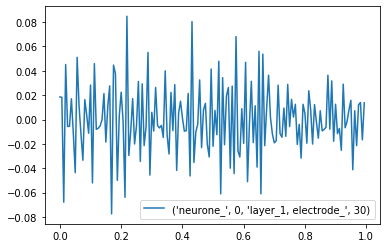

In [322]:
weights = np.array(model.get_weights()) #Convert the weights into np array

plot_weights(weights, electi)            #Plot the weights of the model

In [288]:
weights.shape


(2,)

In [280]:
def plot_predictions(batch_trials, batch_num):
    y_true=format_1[source_Y, batch_trials, stim:]     #recovery of Y in the form of a matrix of 154 * 840
    Time = np.linspace(1, 6.25, (time_points - stim))
    

    x_true = format_1[source_Y, batch_trials, :]
    y_pred = np.zeros((batch_num, time_points - stim))  
    
    for i in range(batch_num):
        k = 0
        while k < time_points - stim:
            y_pred[i, k] = model.predict(x_true[i, k : stim + k].reshape((1, stim)))
            k = k + 1
    print(y_pred.shape)
    
    for i in range(y_true.shape[0]):
        plt.figure()
        plt.plot(Time, y_true[i], label = "True")
        plt.plot(Time, y_pred[i], label = "Predicted")
        plt.legend()
    


(19, 840)


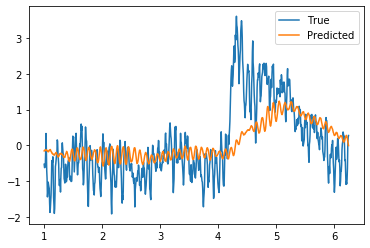

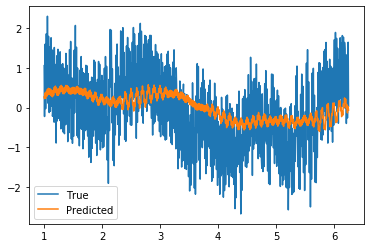

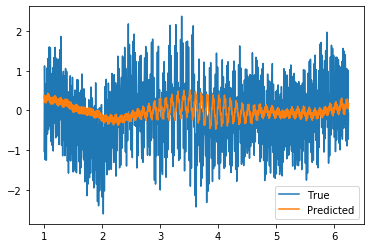

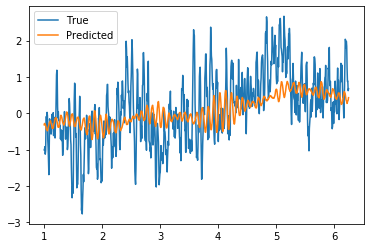

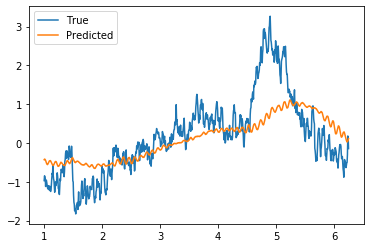

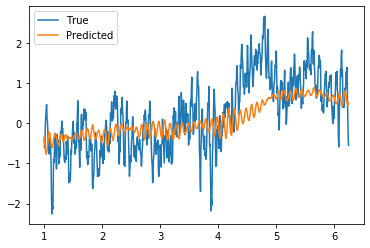

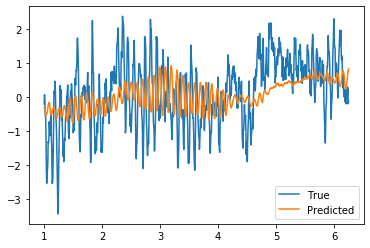

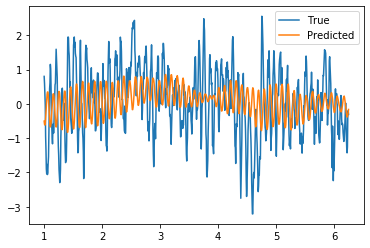

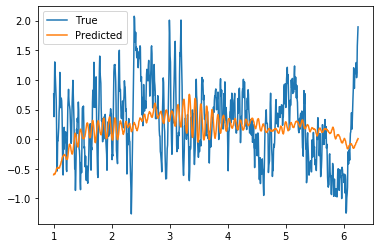

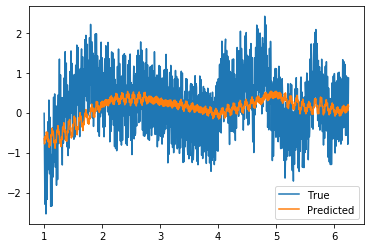

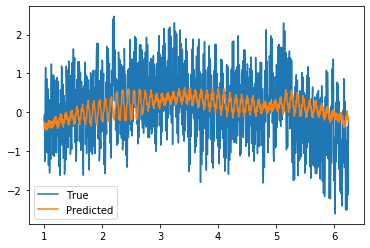

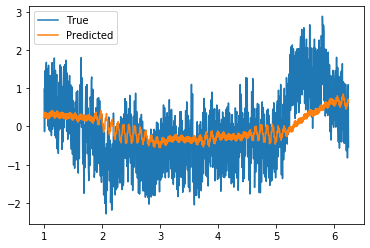

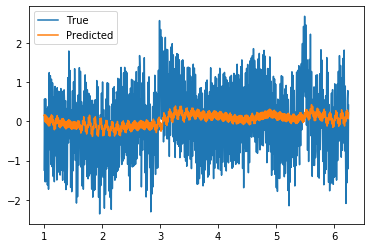

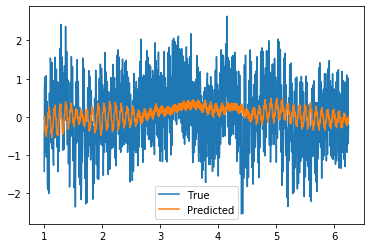

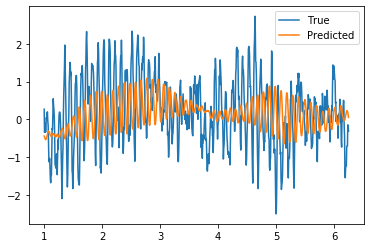

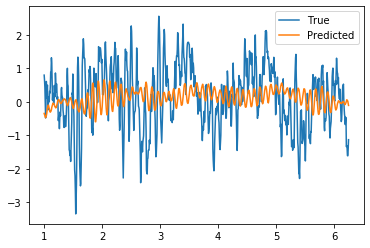

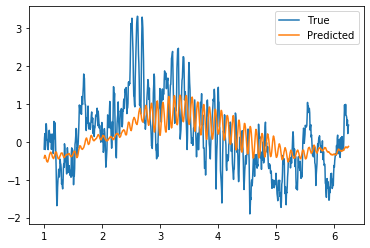

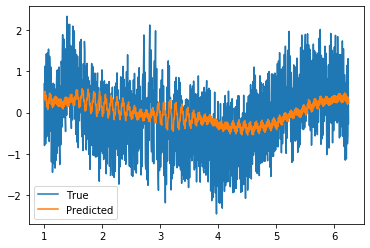

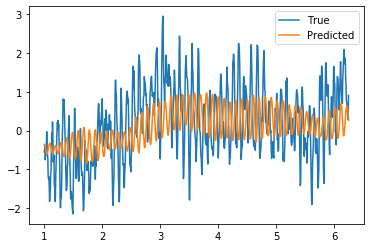

In [281]:
plot_predictions(trials_valid, valid_num)

In [208]:
x_true = format_1[source_Y, trials_valid, :]


x_true.shape

(19, 1000)

In [211]:
x_true[0, 0:160].shape

(160,)